Mounting googledrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Opening gitrepo directory

In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/BanglaImageCaption"


/content/drive/MyDrive/Colab Notebooks/BanglaImageCaption


Installing necessary dependencies

In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 33.3 MB/s 
     |████████████████████████████████| 6.6 MB 17.2 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
     |████████████████████████████████| 596 kB 27.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
from torch.utils import data
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torchvision as tv

from models import utils, caption
from datasets import coco
from configuration import Config
from engine import train_one_epoch, evaluate

from PIL import Image
import os
import json

import torch
from transformers import AutoModelForPreTraining, AutoTokenizer
from configuration import Config
from transformers import BertTokenizer
from datasets.utils import nested_tensor_from_tensor_list, read_json



from models import caption
from datasets import coco, utils
from google.colab import files



Building model from checkpoints

In [5]:
model, criterion = caption.build_model(Config())
model.load_state_dict(torch.load('checkpoint.pth')['model'])

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

<All keys matched successfully>

Upload and test prediction on any image

In [18]:
uploaded = files.upload()

Saving test.png to test.png


/content/drive/MyDrive/Colab Notebooks/BanglaImageCaption/models/position_encoding.py:38: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


একজন নারী ও একটি শিশ আছে ।


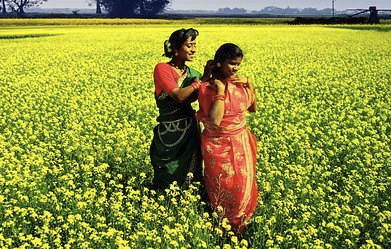

In [19]:

filename = next(iter(uploaded))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

start_token = tokenizer.convert_tokens_to_ids(tokenizer._cls_token)
end_token = tokenizer.convert_tokens_to_ids(tokenizer._sep_token)

image_path = "/content/drive/MyDrive/Colab Notebooks/BanglaImageCaption/" + str(filename)

image = Image.open(image_path)
imgdis = image
image = coco.val_transform(image)
image = image.unsqueeze(0)


def create_caption_and_mask(start_token, max_length):
    caption_template = torch.zeros((1, max_length), dtype=torch.long)
    mask_template = torch.ones((1, max_length), dtype=torch.bool)

    caption_template[:, 0] = start_token
    mask_template[:, 0] = False

    return caption_template, mask_template


caption, cap_mask = create_caption_and_mask(
    start_token, Config().max_position_embeddings)

@torch.no_grad()
def evaluate():
    model.eval()
    for i in range(Config().max_position_embeddings - 1):
        predictions = model(image, caption, cap_mask)
        predictions = predictions[:, i, :]
        predicted_id = torch.argmax(predictions, axis=-1)

        if predicted_id[0] == 102:
            return caption

        caption[:, i+1] = predicted_id[0]
        cap_mask[:, i+1] = False

    return caption


output = evaluate()
result = tokenizer.decode(output[0].tolist(),skip_special_tokens=True)
#result = tokenizer.decode(output[0], skip_special_tokens=True)
print(result)
display(imgdis)
